<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import" data-toc-modified-id="Import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import</a></span></li><li><span><a href="#Config" data-toc-modified-id="Config-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Plot-the-cost" data-toc-modified-id="Plot-the-cost-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot the cost</a></span></li><li><span><a href="#Evaluation-on-benchmark" data-toc-modified-id="Evaluation-on-benchmark-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation on benchmark</a></span><ul class="toc-item"><li><span><a href="#Load-data-set" data-toc-modified-id="Load-data-set-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load data set</a></span></li><li><span><a href="#Loading-the-model" data-toc-modified-id="Loading-the-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Loading the model</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Visualization</a></span></li></ul></li></ul></div>

## Import 

In [1]:
import sys

sys.path.append('..')

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

from tensorflow.python.summary.summary_iterator import summary_iterator
from torch.utils.data import DataLoader

from nets.attention_model import AttentionModel
from problems import CVRP, CVRPTW

## Config

In [3]:
LOG_PATH_LIST = [['trained_models/cvrptw_20/simple_vrptw/events.out.tfevents.1598597965.sm', 
                  'trained_models/cvrptw_20/simple_vrptw/events.out.tfevents.1598640700.sm'], 
                 ['trained_models/cvrptw_20/rollout_vrptw/events.out.tfevents.1598680359.sm'],
                 ['trained_models/cvrptw_20/rollout_two_vehicle/events.out.tfevents.1598716739.sm',
                  'trained_models/cvrptw_20/rollout_two_vehicle/events.out.tfevents.1598728990.sm'],
                 ['trained_models/cvrptw_20/rollout_two_vehicle_time_dependant_attention/events.out.tfevents.1598793948.sm']
                ]

LOG_NAME_LIST = ['no baesline vrptw', 'rollout baseline vrptw', 'rollout two vehicle', 'attention with time']

TRAINED_MODEL_PATH = 'trained_models/cvrptw_20/rollout_two_vehicle_time_dependant_attention/epoch-9.pt'
TRAINED_MODEL_ARGS_PATH = 'trained_models/cvrptw_20/rollout_two_vehicle_time_dependant_attention/args.json'
PROBLEM = CVRPTW

TEST_DATA_SET_PATH = '../data/vrptw/vrptw20_test_seed1111.pkl'
EVALUATION_BATCH_SIZE = 1000
PLOTTING_SAMPLE_COUNT = 5

## Plot the cost 

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


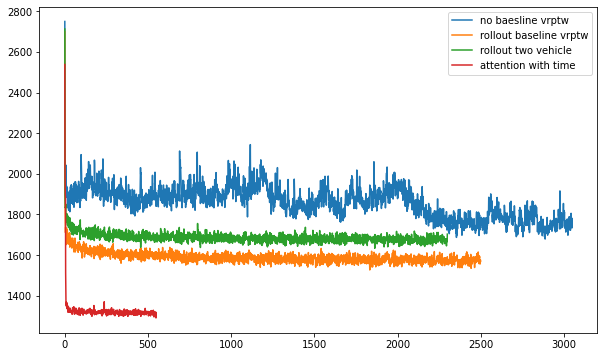

In [4]:
def plot_cost(log_list, legned_names):
    plt.figure(figsize = (10, 6))
    
    for logs in log_list:
        batch_counter = 0
        batch_list = []
        avg_cost_list = []
        for log in logs:
            for i, summary in enumerate(summary_iterator(log)):
                for v in summary.summary.value:
                    if v.tag == 'avg_cost':
                        batch_list.append(batch_counter)
                        batch_counter += 1
                        avg_cost_list.append(v.simple_value)


        plt.plot(batch_list, avg_cost_list)
        
    plt.legend(legned_names)

    plt.show()

plot_cost(LOG_PATH_LIST, LOG_NAME_LIST)

## Evaluation on benchmark 

### Load data set

In [5]:
dataset = PROBLEM.make_dataset(TEST_DATA_SET_PATH)
dataloader = DataLoader(dataset, batch_size=EVALUATION_BATCH_SIZE)
batch_dataset = next(iter(dataloader))

### Loading the model

In [6]:
def _load_model_file(load_path, model):
    """Loads the model with parameters from the file and returns optimizer state dict if it is in the file"""

    # Load the model parameters from a saved state
    load_optimizer_state_dict = None
    print('  [*] Loading model from {}'.format(load_path))

    load_data = torch.load(
        os.path.join(
            os.getcwd(),
            load_path
        ), map_location=lambda storage, loc: storage)

    if isinstance(load_data, dict):
        load_optimizer_state_dict = load_data.get('optimizer', None)
        load_model_state_dict = load_data.get('model', load_data)
    else:
        load_model_state_dict = load_data.state_dict()

    state_dict = model.state_dict()

    state_dict.update(load_model_state_dict)

    model.load_state_dict(state_dict)

    return model, load_optimizer_state_dict

def prepare_model(model_path, model_args_path, problem, decode_type='greedy'):
    with open(model_args_path, 'r') as f:
        args = json.load(f)
        
    model = AttentionModel(
        args['embedding_dim'],
        args['hidden_dim'],
        problem,
        cost_coefficients=args['cost_coefficients'],
        vehicle_count=args['vehicle_count'],
        n_encode_layers=args['n_encode_layers'],
        mask_inner=True,
        mask_logits=True,
        normalization=args['normalization'],
        tanh_clipping=args['tanh_clipping'],
        checkpoint_encoder=args.get('checkpoint_encoder', False),
        shrink_size=args.get('shrink_size', None)
    )
    
    load_data = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict({**model.state_dict(), **load_data.get('model', {})})
    model, _ = _load_model_file(model_path, model)
    model.eval()
    model.set_decode_type(decode_type)
    
    return model

model = prepare_model(TRAINED_MODEL_PATH, TRAINED_MODEL_ARGS_PATH, PROBLEM)

  [*] Loading model from trained_models/cvrptw_20/rollout_two_vehicle_time_dependant_attention/epoch-9.pt


### Evaluation

In [7]:
length, log_p, pi = model(batch_dataset, return_pi=True)
print('average cost on test data set: {}'.format(length.mean()))

average cost on test data set: 1308.856201171875


### Visualization

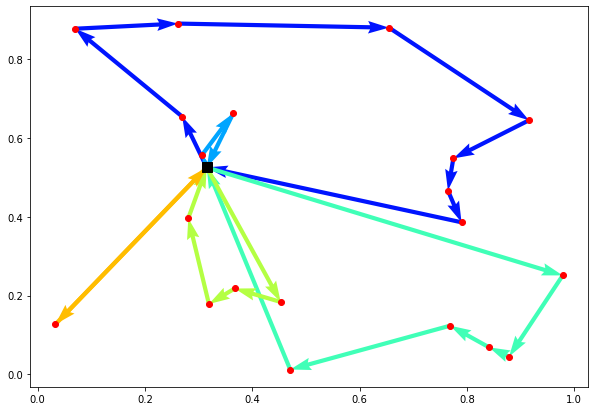

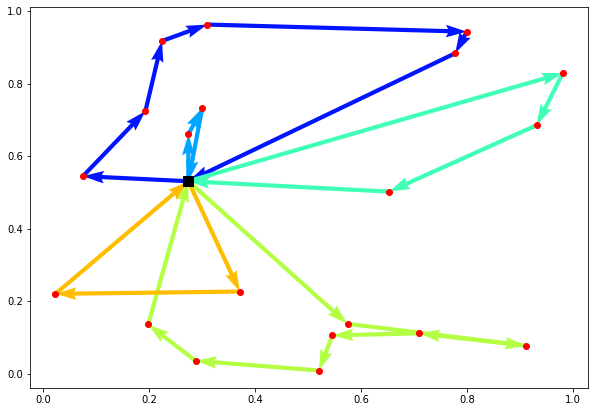

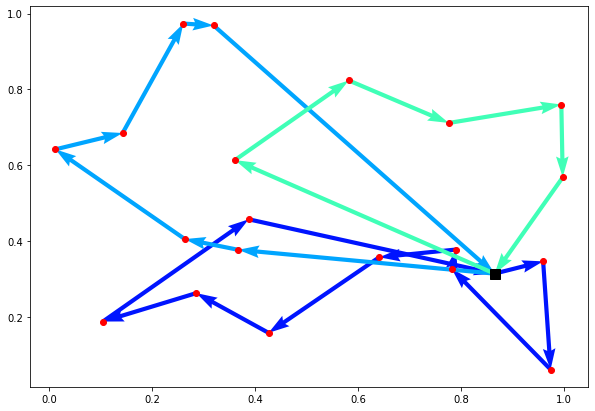

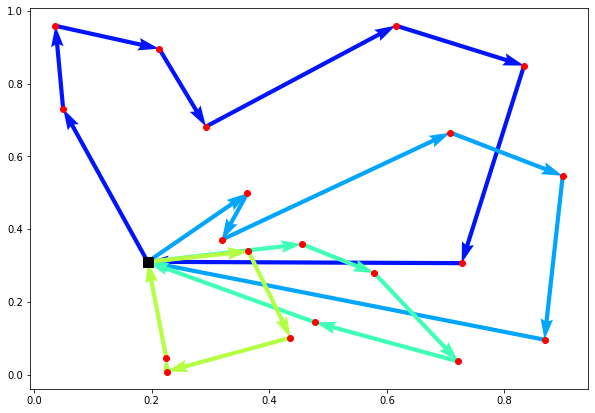

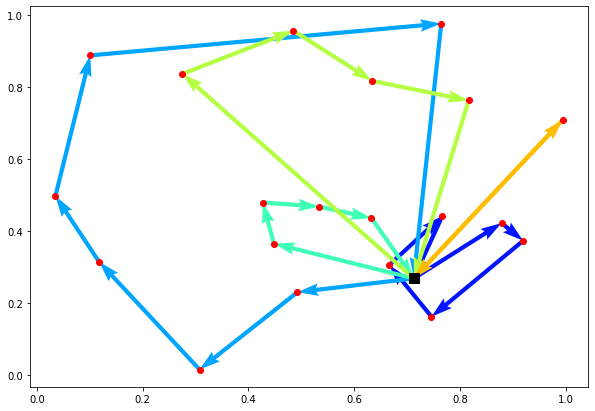

In [170]:
def plot_route(batch_dataset, pi, sample_index=0):
    depot = batch_dataset['depot'][sample_index][None, :]
    locations = batch_dataset['loc'][sample_index]
    locations_with_depot = torch.cat((depot, locations), dim=0).numpy()
    plt.figure(figsize=(10, 7))
    plt.plot(depot[:, 0], depot[:, 1], 'sk', color='k', markersize=10)
    plt.plot(locations[:, 0], locations[:, 1], 'o', color='red')
    
    sample_pi = np.array([0] + pi[sample_index].tolist())
    
    mini_routes = np.split(sample_pi, np.where(sample_pi == 0)[0])
    cmap = plt.cm.jet
    colors = [cmap(i) for i in range(1, 256, 256//len(mini_routes))]
    for mini_route, color in (zip(mini_routes, colors)):
        if len(mini_route) > 1:
            mini_route_end_to_depot = np.pad(mini_route, (0, 1))
            mini_route_locations = locations_with_depot[mini_route_end_to_depot]
            plt.quiver(mini_route_locations[:-1, 0], 
                       mini_route_locations[:-1, 1],
                       mini_route_locations[1:, 0] - mini_route_locations[:-1, 0], 
                       mini_route_locations[1:, 1] - mini_route_locations[:-1, 1], 
                       scale=1, scale_units='xy', angles='xy', color=color)
            
            
sample_index_list = np.random.randint(0, EVALUATION_BATCH_SIZE, (PLOTTING_SAMPLE_COUNT,))
for sample_index in sample_index_list:
    plot_route(batch_dataset, pi, sample_index)